In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D,Dropout
import tensorflow as tf
import splitfolders
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go
import itertools
import plotly.express as px

In [3]:
#data directory
data_dir = pathlib.Path("D:\\python\\meow\\pruby\\ds\\pista\\Pistachio_Image_Dataset")
#print all folders in the data directory
print("Folders in the data directory:")
for item in data_dir.iterdir():
    print(item)



Folders in the data directory:
D:\python\meow\pruby\ds\pista\Pistachio_Image_Dataset\Pistachio_16_Features_Dataset
D:\python\meow\pruby\ds\pista\Pistachio_Image_Dataset\Pistachio_28_Features_Dataset
D:\python\meow\pruby\ds\pista\Pistachio_Image_Dataset\Pistachio_Image_Dataset
D:\python\meow\pruby\ds\pista\Pistachio_Image_Dataset\Pistachio_Image_Dataset_Request.txt


In [4]:
#all of the images
images = glob.glob("D:\\python\\meow\\pruby\\ds\\pista\\Pistachio_Image_Dataset\\Pistachio_Image_Dataset\\*\\*.jpg")
#number of images
print("Number of images: ", len(images))

images = pd.Series(images)


Number of images:  2148


In [5]:
df = pd.DataFrame()

#generate field with Filename
df['Filename'] = images.map(lambda img_name: img_name.split('\\')[-1])

#generate field with ClassID
df['ClassID'] = images.map(lambda img_name: img_name.split('\\')[-2])

df.head()

,Filename,ClassID
0,kirmizi (1).jpg,Kirmizi_Pistachio
1,kirmizi (10).jpg,Kirmizi_Pistachio
2,kirmizi (11).jpg,Kirmizi_Pistachio
3,kirmizi (12).jpg,Kirmizi_Pistachio
4,kirmizi (13).jpg,Kirmizi_Pistachio


In [6]:
class_id_distributionTotal = df['ClassID'].value_counts()
class_id_distributionTotal.head(10)

Kirmizi_Pistachio    1232
Siirt_Pistachio       916
Name: ClassID, dtype: int64

In [7]:
#data distribution
fig = px.bar(class_id_distributionTotal, x=class_id_distributionTotal.index, y=class_id_distributionTotal.values, color=class_id_distributionTotal.index)
fig.update_layout(title_text='Data distribution', xaxis_title="Class ID", yaxis_title="Number of images")
fig.show()

In [8]:
#percentage of data distribution in a pie chart
fig = px.pie(class_id_distributionTotal, values=class_id_distributionTotal.values, names=class_id_distributionTotal.index, title='Data distribution')
fig.show()


In [9]:
#split data into train, validation and test sets
splitfolders.ratio("D:\\python\\meow\\pruby\\ds\\pista\\Pistachio_Image_Dataset\\Pistachio_Image_Dataset", output="output", seed=1337, ratio=(.8, 0.1,0.1), group_prefix=None) # default values

#show the folders in the output directory
print("Folders in the output directory:")
for item in pathlib.Path("output").iterdir():
    print(item)
#show items in these directories
print("Items in the train directory:")
for item in pathlib.Path("output\\train").iterdir():
    print(item)
print("Items in the val directory:")
for item in pathlib.Path("output\\val").iterdir():
    print(item)
print("Items in the test directory:")
for item in pathlib.Path("output\\test").iterdir():
    print(item)

Copying files: 2148 files [00:02, 724.55 files/s]

Folders in the output directory:
output\test
output\train
output\val
Items in the train directory:
output\train\Kirmizi_Pistachio
output\train\Siirt_Pistachio
Items in the val directory:
output\val\Kirmizi_Pistachio
output\val\Siirt_Pistachio
Items in the test directory:
output\test\Kirmizi_Pistachio
output\test\Siirt_Pistachio


In [10]:
train_dir = pathlib.Path("output\\train")
val_dir = pathlib.Path("output\\val")
test_dir = pathlib.Path("output\\test")
class_names_train = os.listdir(train_dir)
class_names_val = os.listdir(val_dir)
class_names_test = os.listdir(test_dir)


In [11]:
train_images = glob.glob("output\\train\\*\\*.jpg")
total_train_images = train_images
print("Number of train images: ", len(train_images))
test_images = glob.glob("output\\test\\*\\*.jpg")
total_test_images = test_images
print("Number of test images: ", len(test_images))
val_images = glob.glob("output\\val\\*\\*.jpg")
total_val_images = val_images
print("Number of val images: ", len(val_images))


Number of train images:  1717
Number of test images:  217
Number of val images:  214


In [12]:
#chart for the data distribution of train, val and test sets
random_x = [len(train_images), len(val_images), len(test_images)]
names = ['Train', 'Validation', 'Test']
fig = go.Figure(data=[go.Pie(labels=names, values=random_x, hole=.3)])
fig.update_layout(title_text='Data distribution', xaxis_title="Class ID", yaxis_title="Number of images")
fig.show()

In [13]:
train_image_names = pd.Series(train_images)
train_df = pd.DataFrame()

#generate field with Filename
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split('\\')[-1])

#generate field with ClassID
train_df['ClassID'] = train_image_names.map(lambda img_name: img_name.split('\\')[-2])

train_df.head()


,Filename,ClassID
0,kirmizi (10).jpg,Kirmizi_Pistachio
1,kirmizi (11).jpg,Kirmizi_Pistachio
2,kirmizi (12).jpg,Kirmizi_Pistachio
3,kirmizi (13).jpg,Kirmizi_Pistachio
4,kirmizi (15).jpg,Kirmizi_Pistachio


In [14]:
class_id_distribution_Train = train_df['ClassID'].value_counts()
class_id_distribution_Train.head(10)

Kirmizi_Pistachio    985
Siirt_Pistachio      732
Name: ClassID, dtype: int64

In [15]:
#distribution of train data
fig = px.bar(class_id_distribution_Train, x=class_id_distribution_Train.index, y=class_id_distribution_Train.values, color=class_id_distribution_Train.index)
fig.update_layout(title_text='Data distribution', xaxis_title="Class ID", yaxis_title="Number of images")
fig.show()


In [16]:
#pie chart of train data distribution in percentage
fig = px.pie(class_id_distribution_Train, values=class_id_distribution_Train.values, names=class_id_distribution_Train.index, title='Data distribution')
fig.show()


In [17]:
#distribution of test data
test_image_names = pd.Series(test_images)
test_df = pd.DataFrame()

#generate field with Filename
test_df['Filename'] = test_image_names.map(lambda img_name: img_name.split('\\')[-1])

#generate field with ClassID
test_df['ClassID'] = test_image_names.map(lambda img_name: img_name.split('\\')[-2])

test_df.head()

,Filename,ClassID
0,kirmizi (32).jpg,Kirmizi_Pistachio
1,kirmizi (41).jpg,Kirmizi_Pistachio
2,kirmizi (42).jpg,Kirmizi_Pistachio
3,kirmizi (55).jpg,Kirmizi_Pistachio
4,kirmizi (65).jpg,Kirmizi_Pistachio


In [18]:
class_id_distribution_test = test_df['ClassID'].value_counts()
class_id_distribution_test.head(10)

Kirmizi_Pistachio    124
Siirt_Pistachio       93
Name: ClassID, dtype: int64

In [19]:
#distribution of test data
fig = px.bar(class_id_distribution_test, x=class_id_distribution_test.index, y=class_id_distribution_test.values, color=class_id_distribution_test.index)
fig.update_layout(title_text='Data distribution', xaxis_title="Class ID", yaxis_title="Number of images")
fig.show()


In [20]:
#pie chart of test data distribution in percentage
fig = px.pie(class_id_distribution_test, values=class_id_distribution_test.values, names=class_id_distribution_test.index, title='Data distribution')
fig.show()

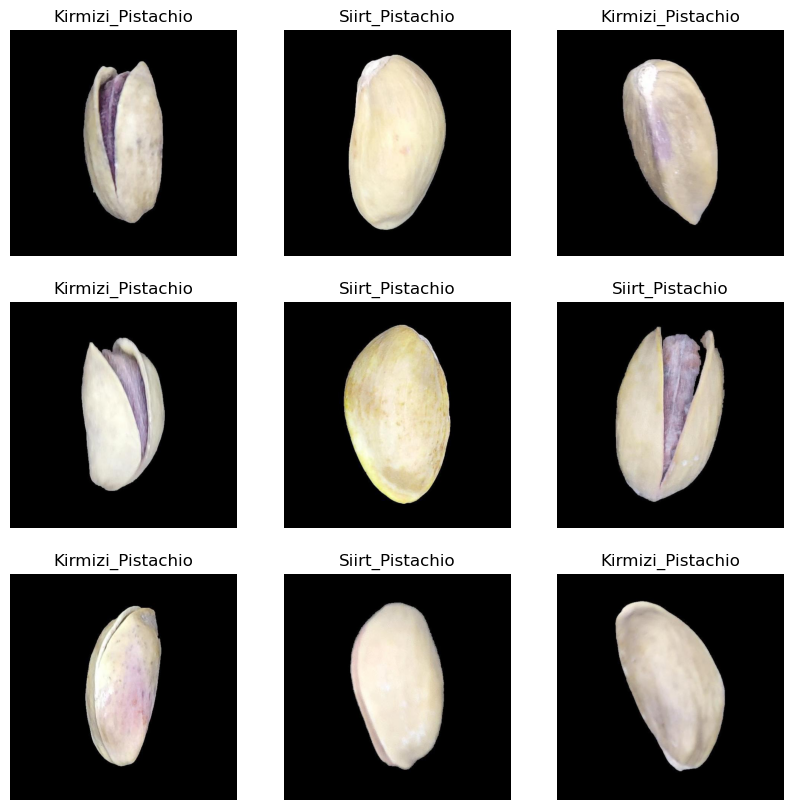

In [21]:
#display some images with labels

plot_df = train_df.sample(n=9).reset_index(drop=True)
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread("output\\train\\" + plot_df["ClassID"][i] + "\\" + plot_df["Filename"][i])
    plt.imshow(img)
    plt.title(plot_df["ClassID"][i])
    plt.axis("off")


In [22]:
#image data generator
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                      rotation_range=20,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='binary')


Found 1717 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [23]:
#efficientnet model
from tensorflow.keras.applications import EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()
#save the model
base_model.save('efficientnet.h5')



Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

d:\python\odyn\anak2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [24]:
#fine tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

#compile the model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,852
Trainable params: 3,841,629
Non-trainable params: 209,223
_________________________________________________________________


In [25]:
#train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    verbose=1)
#save the model
model.save('efficientnet_finetuned.h5')


Epoch 1/10


: 

: 

In [1]:
#plot the accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


NameError: name 'plt' is not defined

In [ ]:
#cannot run this code because of the memory error - NEED MORE RAM